## 🧩 EDA Parte 2 — Temporal
### *Análisis Exploratorio de Datos Hospitalarios (2005–2023)*


In [1]:
# ==========================================================
# 📦 1. Librerías y estilo
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("crest")

# ==========================================================
# 📁 2. Ubicación del dataset
# ==========================================================
file_name = "dataset_estacional_final.csv"
candidate_paths = [
    Path.cwd() / file_name,
    Path.cwd() / "data" / file_name,
    Path.home() / "Desktop" / "No Country" / "data" / file_name
]

for candidate in candidate_paths:
    if candidate.exists():
        file_path = candidate
        break
else:
    raise FileNotFoundError(
        f"No se encontró '{file_name}' en las rutas:\n" +
        "\n".join(str(p) for p in candidate_paths)
    )

# ==========================================================
# 🔎 3. Detección de separador y carga del dataset
# ==========================================================
with open(file_path, "r", encoding="latin1") as f:
    primera_linea = f.readline()
sep = ";" if primera_linea.count(";") > primera_linea.count(",") else ","

df = pd.read_csv(file_path, sep=sep, encoding="latin1")

In [2]:
# ==========================================================
# 🔍 4. Verificación de estructura temporal y nulos
# ==========================================================
print("Columnas principales:")
print(df.columns.to_list(), "\n")

print("Tipos de datos:")
print(df.dtypes, "\n")

# Nulos relevantes
nulos = df.isna().sum()
print("Nulos detectados (solo los > 0):")
print(nulos[nulos > 0], "\n")

# Cobertura de años y meses
print("📅 Rango de años:", df["anio"].min(), "-", df["anio"].max())
print("📆 Meses únicos:", sorted(df["mes"].unique()))
print("🔁 Registros por año:")
print(df["anio"].value_counts().sort_index())

Columnas principales:
['anio', 'region_sanitaria', 'municipio_id', 'municipio_nombre', 'establecimiento_nombre', 'dependencia', 'consultas_odontologicas', 'consultas_medicas', 'consultas_paramedicas', 'interconsultas', 'egresos', 'dias_camas_disponible', 'promedio_camas_disponibles', 'pacientes_dias', 'porcentaje_ocupacion', 'dias_estadia', 'promedio_dias_estadia', 'defunciones', 'giro_de_camas', 'tasa_mortalidad_hospitalaria', 'urgencias', 'cirugias', 'quirofanos', 'medicos', 'enfermeros', 'inventario', 'covid_dummy', 'mes', 'clima', 'feriados', 'establecimiento_id'] 

Tipos de datos:
anio                              int64
region_sanitaria                 object
municipio_id                      int64
municipio_nombre                 object
establecimiento_nombre           object
dependencia                      object
consultas_odontologicas           int64
consultas_medicas                 int64
consultas_paramedicas             int64
interconsultas                    int64
egresos

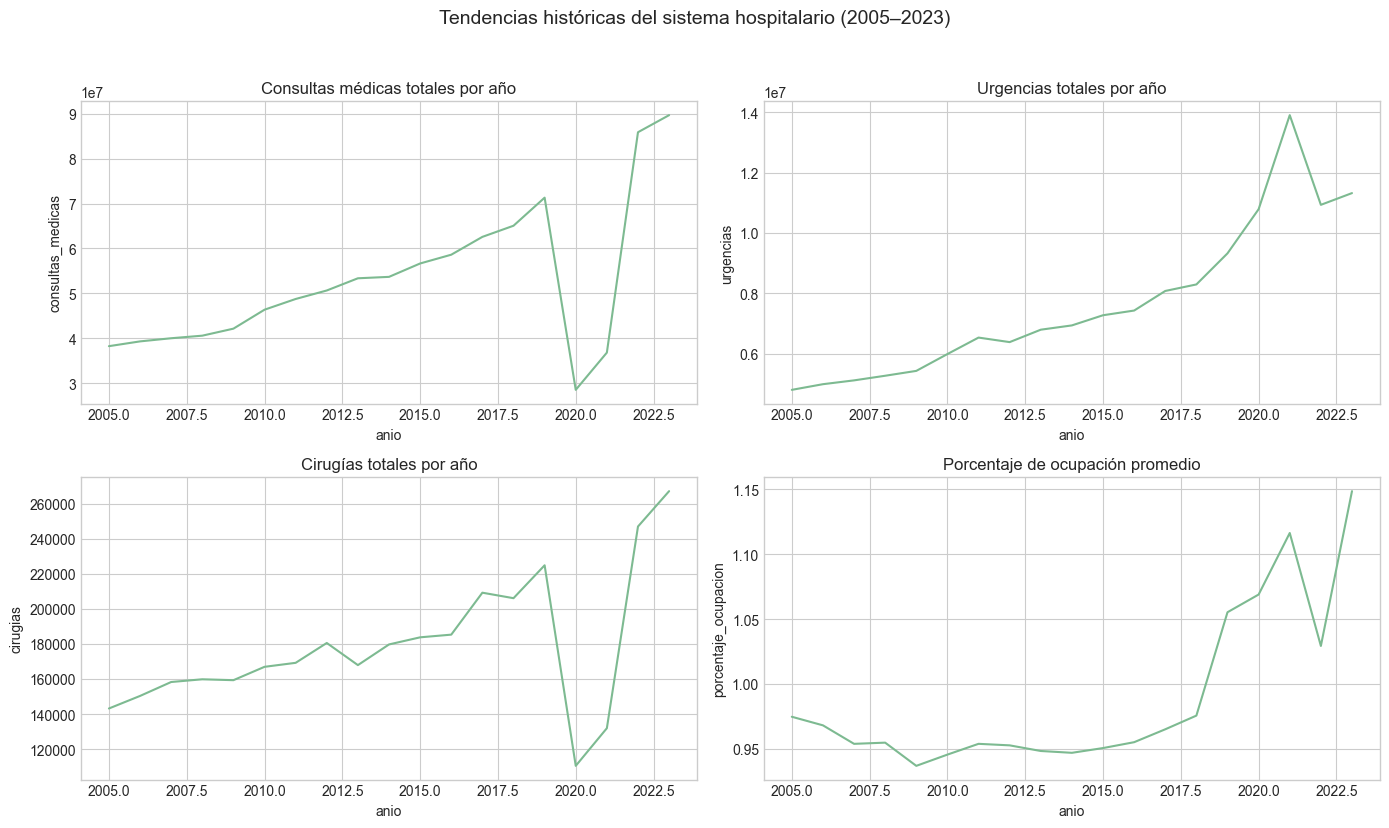

In [3]:
# ==========================================================
# 📈 5. Tendencias históricas generales (2005–2023)
# ==========================================================

# --- Agregación anual (suma para volúmenes, promedio para tasas)
agg_dict = {
    "consultas_medicas": "sum",
    "urgencias": "sum",
    "cirugias": "sum",
    "porcentaje_ocupacion": "mean",
    "promedio_camas_disponibles": "mean"
}

df_anual = df.groupby("anio", as_index=False).agg(agg_dict)

# --- Graficar tendencias clave
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

sns.lineplot(data=df_anual, x="anio", y="consultas_medicas", ax=axes[0])
axes[0].set_title("Consultas médicas totales por año")

sns.lineplot(data=df_anual, x="anio", y="urgencias", ax=axes[1])
axes[1].set_title("Urgencias totales por año")

sns.lineplot(data=df_anual, x="anio", y="cirugias", ax=axes[2])
axes[2].set_title("Cirugías totales por año")

sns.lineplot(data=df_anual, x="anio", y="porcentaje_ocupacion", ax=axes[3])
axes[3].set_title("Porcentaje de ocupación promedio")

plt.suptitle("Tendencias históricas del sistema hospitalario (2005–2023)", fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

## 🟩 Conclusiones - Tendencias temporales 2005-2023

- **Consultas médicas:** crecimiento sostenido desde 2005 hasta 2019, caída pronunciada durante 2020 (impacto COVID-19) y fuerte recuperación posterior en 2022-2023, superando niveles prepandemia.  
- **Urgencias:** tendencia ascendente sostenida durante todo el período, con picos marcados en 2020-2021 vinculados a la pandemia y un mantenimiento elevado después.  
- **Cirugías:** evolución positiva hasta 2019, fuerte caída en 2020 por postergación de intervenciones, seguida de una recuperación intensa en 2022-2023.  
- **Ocupación de camas:** descenso gradual entre 2005 y 2018, incremento marcado a partir de 2019 y pico posterior a la pandemia (2022–2023), reflejando la reactivación de internaciones y cirugías.

➡️ En conjunto, los indicadores muestran una dinámica coherente con el impacto del COVID-19: contracción temporal de la actividad asistencial y recuperación progresiva del sistema hospitalario en la pospandemia.

📊 Promedios por período (valores reales):

                      Pre-COVID    COVID  Post-COVID
consultas_medicas       2584.49  1227.86     3234.72
urgencias                333.91   463.67      410.08
cirugias                   8.17     4.55        9.47
porcentaje_ocupacion       1.02     1.09        1.09 



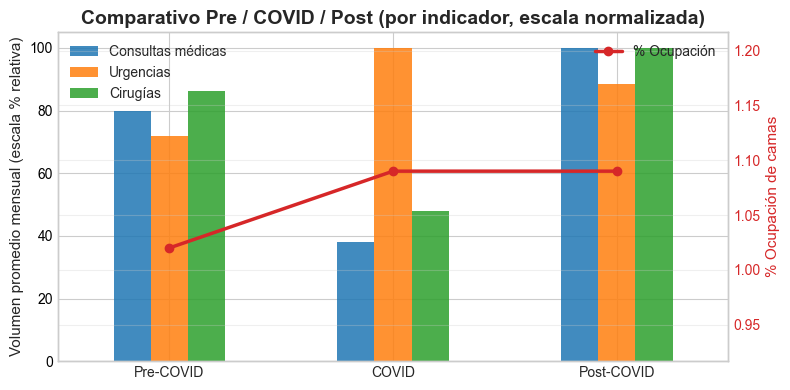

In [4]:
# ==========================================================
# 📊 6. Comparativo Pre / COVID / Post
# ==========================================================

# --- Definir periodos de análisis
periodos = {
    "Pre-COVID": [2018, 2019],
    "COVID": [2020, 2021],
    "Post-COVID": [2022, 2023]
}

# --- Calcular promedios por periodo
vars_clave = ["consultas_medicas", "urgencias", "cirugias", "porcentaje_ocupacion"]
df_comp = pd.DataFrame(
    {p: df[df["anio"].isin(años)][vars_clave].mean() for p, años in periodos.items()}
).round(2)

print("📊 Promedios por período (valores reales):\n")
print(df_comp, "\n")

# --- Normalizar volúmenes para comparar tendencias
df_scaled = df_comp.copy()
for indicador in ["consultas_medicas", "urgencias", "cirugias"]:
    df_scaled.loc[indicador] = df_scaled.loc[indicador] / df_scaled.loc[indicador].max() * 100

# --- Gráfico combinado barras + línea
fig, ax1 = plt.subplots(figsize=(8, 4))

df_scaled.loc[["consultas_medicas", "urgencias", "cirugias"]].T.plot(
    kind="bar",
    ax=ax1,
    color=["#1f77b4", "#ff7f0e", "#2ca02c"],
    alpha=0.85
)
ax1.set_ylabel("Volumen promedio mensual (escala % relativa)", fontsize=11)
ax1.tick_params(axis="y", labelcolor="black")
plt.xticks(rotation=0)

ax2 = ax1.twinx()
df_comp.loc["porcentaje_ocupacion"].plot(
    ax=ax2,
    color="#d62728",
    marker="o",
    linewidth=2.5,
    label="% Ocupación"
)
ax2.set_ylabel("% Ocupación de camas", color="#d62728", fontsize=11)
ax2.tick_params(axis="y", labelcolor="#d62728")
mean_occ = df_comp.loc["porcentaje_ocupacion"].mean()
ax2.set_ylim(mean_occ - 0.15, mean_occ + 0.15)

plt.title(
    "Comparativo Pre / COVID / Post (por indicador, escala normalizada)",
    fontsize=14,
    weight="bold"
)
ax1.legend(["Consultas médicas", "Urgencias", "Cirugías"], loc="upper left")
ax2.legend(["% Ocupación"], loc="upper right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 🟩 Conclusiones - Comparativo Pre / COVID / Post (2018–2023)

- **Consultas médicas:** caída pronunciada durante la pandemia (reducción cercana al 50%), seguida de una recuperación sólida en el período post-COVID, alcanzando y superando los niveles previos.
- **Urgencias:** aumento significativo en la etapa COVID-19, manteniendo valores elevados después, lo que evidencia una presión sostenida sobre los servicios de emergencia.
- **Cirugías:** fuerte descenso durante la pandemia por suspensión de procedimientos electivos, con un repunte posterior que supera ligeramente el nivel prepandemia.
- **Ocupación de camas:** leve incremento durante la pandemia (asociado al tratamiento de pacientes COVID) y estabilización posterior, reflejando una recuperación del uso normal del sistema.

➡️ En conjunto, los indicadores muestran el impacto del COVID-19 como una disrupción abrupta en la actividad hospitalaria, seguida de una fase de compensación y reactivación que devuelve al sistema a niveles superiores de demanda asistencial.

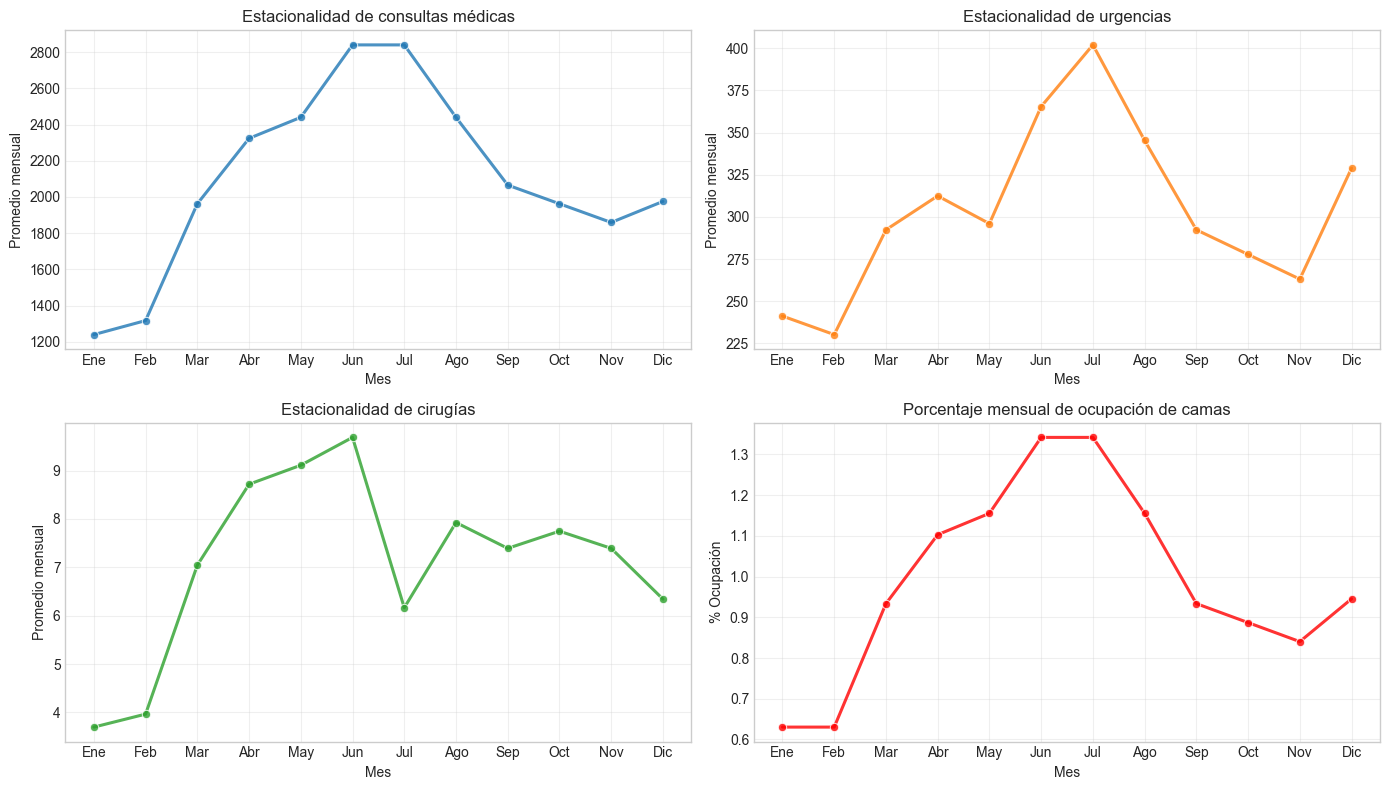

In [5]:
# ==========================================================
# 🌤️ 7. Estacionalidad mensual 
# ==========================================================

df_estacional = df.groupby("mes", as_index=False).mean(numeric_only=True)

meses = {
    1: "Ene", 2: "Feb", 3: "Mar", 4: "Abr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Ago", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dic"
}
df_estacional["mes_nombre"] = df_estacional["mes"].map(meses)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sns.lineplot(
    data=df_estacional, x="mes_nombre", y="consultas_medicas",
    marker="o", linewidth=2.2, alpha=0.8, color="#1f77b4", ax=axes[0, 0]
)
axes[0, 0].set_title("Estacionalidad de consultas médicas")
axes[0, 0].set_xlabel("Mes")
axes[0, 0].set_ylabel("Promedio mensual")
axes[0, 0].grid(alpha=0.3)

sns.lineplot(
    data=df_estacional, x="mes_nombre", y="urgencias",
    marker="o", linewidth=2.2, alpha=0.8, color="#ff7f0e", ax=axes[0, 1]
)
axes[0, 1].set_title("Estacionalidad de urgencias")
axes[0, 1].set_xlabel("Mes")
axes[0, 1].set_ylabel("Promedio mensual")
axes[0, 1].grid(alpha=0.3)

sns.lineplot(
    data=df_estacional, x="mes_nombre", y="cirugias",
    marker="o", linewidth=2.2, alpha=0.8, color="#2ca02c", ax=axes[1, 0]
)
axes[1, 0].set_title("Estacionalidad de cirugías")
axes[1, 0].set_xlabel("Mes")
axes[1, 0].set_ylabel("Promedio mensual")
axes[1, 0].grid(alpha=0.3)

sns.lineplot(
    data=df_estacional, x="mes_nombre", y="porcentaje_ocupacion",
    marker="o", linewidth=2.2, alpha=0.8, color="red", ax=axes[1, 1]
)
axes[1, 1].set_title("Porcentaje mensual de ocupación de camas")
axes[1, 1].set_xlabel("Mes")
axes[1, 1].set_ylabel("% Ocupación")
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

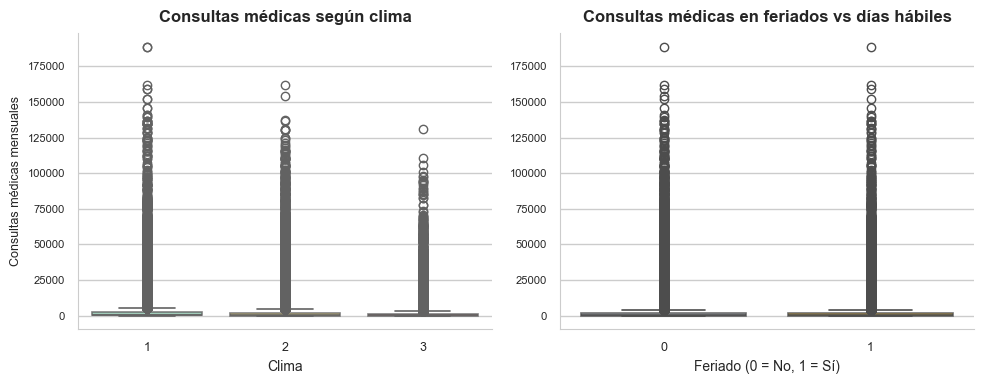

In [6]:
# ==========================================================
# 🎯 8. Consulta médica vs clima y feriados (boxplots)
# ==========================================================

sns.set_theme(style="whitegrid", rc={"axes.edgecolor": "0.8", "axes.linewidth": 0.8})
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(
    data=df,
    x="clima",
    y="consultas_medicas",
    hue="clima",
    palette=["#7FC8A9", "#FFE156", "#FF6B6B"],
    legend=False,
    linewidth=1.2,
    boxprops=dict(alpha=0.8),
    ax=axes[0]
)
axes[0].set_title("Consultas médicas según clima", fontsize=12, fontweight="bold", pad=8)
axes[0].set_xlabel("Clima", fontsize=10)
axes[0].set_ylabel("Consultas médicas mensuales", fontsize=9)
axes[0].tick_params(axis="x", labelsize=9)
axes[0].tick_params(axis="y", labelsize=8)
sns.despine(ax=axes[0], left=False, bottom=False)

sns.boxplot(
    data=df,
    x="feriados",
    y="consultas_medicas",
    hue="feriados",
    palette=["#B0BEC5", "#FFB703"],
    legend=False,
    linewidth=1.2,
    boxprops=dict(alpha=0.8),
    ax=axes[1]
)
axes[1].set_title("Consultas médicas en feriados vs días hábiles", fontsize=12, fontweight="bold", pad=8)
axes[1].set_xlabel("Feriado (0 = No, 1 = Sí)", fontsize=10)
axes[1].set_ylabel("")
axes[1].tick_params(axis="x", labelsize=9)
axes[1].tick_params(axis="y", labelsize=8)
sns.despine(ax=axes[1], left=False, bottom=False)

plt.tight_layout()
plt.show()

## 🟩 Conclusiones - Factores estacionales (clima y feriados)

- **Clima:** las consultas médicas muestran leves variaciones entre climas cálidos, templados y fríos, sin diferencias marcadas. Sin embargo, los meses fríos tienden a concentrar una ligera mayor demanda, posiblemente vinculada a patologías respiratorias y estacionales.
- **Feriados:** no se observan diferencias significativas entre días hábiles y feriados, lo que sugiere una continuidad operativa del sistema hospitalario gracias al funcionamiento de guardias y emergencias.


➡️ En conjunto, ambos factores indican que el sistema mantiene una actividad estable durante todo el año, con variaciones menores atribuibles a la estacionalidad invernal más que a los feriados.